In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
url = 'drive/MyDrive/a/'
url = ''

MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'
OUTPUT_PATH = '/resources/bert-fa-base-uncased-ner-taaghceh/tf_model.bin'

# Preprocessing

## Importing Libraries

In [3]:
# !pip install hazm

In [4]:
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import re
from hazm import InformalNormalizer, Normalizer
from transformers import BertTokenizer
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

## preprocessing prepared data (taghche.csv)

In [6]:
tqdm.pandas()

In [7]:
prepared_data: pd.DataFrame = pd.read_csv(url + 'datasets/taghche.csv')
prepared_data = prepared_data[['comment', 'bookname', 'bookID']]

In [8]:
prepared_data.head()

,comment,bookname,bookID
0,اسم کتاب No one writes to the Colonel\nترجمش...,سرهنگ کسی ندارد برایش نامه بنویسد,3.0
1,"طاقچه عزیز،نام کتاب""کسی به سرهنگ نامه نمینویسد...",سرهنگ کسی ندارد برایش نامه بنویسد,3.0
2,بنظرم این اثر مارکز خیلی از صد سال تنهایی که ب...,سرهنگ کسی ندارد برایش نامه بنویسد,3.0
3,به نظر کتاب خوبی میومد اما من از ترجمش خوشم نی...,سرهنگ کسی ندارد برایش نامه بنویسد,3.0
4,کتاب خوبی است,سرهنگ کسی ندارد برایش نامه بنویسد,3.0


In [9]:
chars_stop_words = ''
with open(url + 'stopwords/chars (without digits).txt', 'r', encoding='utf-8') as file:
    chars_stop_words = ''.join(file.read().splitlines())

chars_stop_words = chars_stop_words.replace('[', '\[')
chars_stop_words = chars_stop_words.replace(']', '\]')
chars_pattern = re.compile(f'[{chars_stop_words}]')
chars_pattern

re.compile(r'[\ufeff!"#()*,-./:\[\]«»،؛؟…$ًٌٍَُِّْءٰٔ﷼]', re.UNICODE)

In [10]:
# https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
emojis_pattern = re.compile("["
                            u"\U0001F600-\U0001F64F"  # emoticons
                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            "]+")
emojis_pattern

re.compile(r'[😀-🙏🌀-🗿🚀-\U0001f6ff\U0001f1e0-🇿]+', re.UNICODE)

In [11]:
def elementary_preprocess(text):
    global chars_pattern, emojis_pattern

    text = str(text)
    text = chars_pattern.sub(r' ', text)
    text = emojis_pattern.sub(r' ', text)
    return text.translate(str.maketrans('0123456789', '۰۱۲۳۴۵۶۷۸۹'))


def higher_preprocess(text, is_informal=False):
    global normalizer, tokenizer

    text = str(text)
    
    if is_informal:
        text = informal_normalizer_function(text)
    else:
        text = normalizer.normalize(text)
    
    text = tokenizer.tokenize(text)
    return text


# customizing InformalNormalizer().normalize()
# For seeing differences, you can see InformalNormalizer().normalize() method
def informal_normalizer_function(text):
    global informal_normalizer
    text = str(text)

    informal_normalizer = InformalNormalizer()
    text = Normalizer.normalize(informal_normalizer, text)
    sents = [
        informal_normalizer.word_tokenizer.tokenize(sentence)
        for sentence in informal_normalizer.sent_tokenizer.tokenize(text)
    ]

    normalized = [[informal_normalizer.normalized_word(word)[0] for word in sent] for sent in sents]
    normalized = np.array(normalized, dtype=object)
    return np.hstack(normalized)

In [12]:
normalizer = Normalizer()
informal_normalizer = InformalNormalizer()
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH)

In [13]:
for column in prepared_data.columns:
    if column == 'bookID':
        continue
    
    print(f'Column: {column}')
    prepared_data[column] = prepared_data[column].progress_apply(elementary_preprocess)

Column: comment


  0%|          | 0/69829 [00:00<?, ?it/s]

Column: bookname


  0%|          | 0/69829 [00:00<?, ?it/s]

In [14]:
# When you want to do informal normalization, uncomment following lines
# for column in prepared_data.columns:
#     if column == 'bookID':
#         continue
# 
#     progress_bar = tqdm(total=len(prepared_data[column]))
#     prepared_data[column] = prepared_data[column].progress_apply(lambda x: higher_preprocess(x, True))


for column in prepared_data.columns:
    if column == 'bookID':
        continue
    
    print(f'Column: {column}')
    prepared_data[column] = prepared_data[column].progress_apply(higher_preprocess)

Column: comment


  0%|          | 0/69829 [00:00<?, ?it/s]

Column: bookname


  0%|          | 0/69829 [00:00<?, ?it/s]

In [15]:
# prepared_data.to_csv('datasets/preprocessed/preprocessed_taghche.csv')
# prepared_data = pd.read_csv('datasets/preprocessed/preprocessed_taghche.csv')

In [16]:
before_dropping = len(prepared_data)
prepared_data = prepared_data[prepared_data['comment'].apply(lambda x: len(x)) != 0]
print(f'Dropped {before_dropping - len(prepared_data)} rows with empty comment.')

Dropped 434 rows with empty comment.


In [17]:
before_dropping = len(prepared_data)
prepared_data = prepared_data.dropna(subset=['bookID'])
print(f'Dropped {before_dropping - len(prepared_data)} rows with NaN bookID.')

Dropped 39 rows with NaN bookID.


In [18]:
prepared_data.head()

,comment,bookname,bookID
0,"[اسم, کتاب, no, one, write, ##s, to, the, colo...","[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]",3.0
1,"[طاقچه, عزیز, نام, کتاب, کسی, به, سرهنگ, نامه,...","[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]",3.0
2,"[بنظرم, این, اثر, مارکز, خیلی, از, صد, سال, تن...","[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]",3.0
3,"[به, نظر, کتاب, خوبی, میومد, اما, من, از, ترجم...","[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]",3.0
4,"[کتاب, خوبی, است]","[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]",3.0


## preprocessing crawled data (books_data_part_*.csv)

In [19]:
ALL_PARTS_LEN = 19
crawled_data: pd.DataFrame = pd.read_csv(url + 'datasets/books data/books_data_part_1.csv')
for i in range(2, ALL_PARTS_LEN + 1):
    crawled_data = pd.concat([crawled_data, pd.read_csv(url + f'datasets/books data/books_data_part_{i}.csv')],
                             ignore_index=True)

In [20]:
# sort authors in order to drop duplicates
new_author_function = lambda x: ' $ '.join(sorted(str(x).split(' $ ')))
crawled_data['author'] = crawled_data['author'].apply(new_author_function)

In [21]:
before_dropping = len(crawled_data)
crawled_data = crawled_data.drop_duplicates()
print(f'Dropped {before_dropping - len(crawled_data)} duplicates.')

Dropped 4 duplicates.


In [22]:
before_dropping = len(crawled_data)
crawled_data = crawled_data.dropna(subset=['id'])
print(f'Dropped {before_dropping - len(crawled_data)} rows with NaN id.')

Dropped 1 rows with NaN id.


In [23]:
new_author_function = lambda x: set(x.split(' $ '))
crawled_data['author'] = crawled_data['author'].apply(new_author_function)

In [24]:
# convert each author to an independent row
# because I want to find each author independently in the comments
crawled_data = crawled_data.explode('author')
crawled_data = crawled_data.reset_index(drop=True)

In [25]:
for column in crawled_data.columns:
    if column == 'id':
        continue
    
    print(f'Column: {column}')
    crawled_data[column] = crawled_data[column].progress_apply(elementary_preprocess)

Column: name


  0%|          | 0/200574 [00:00<?, ?it/s]

Column: author


  0%|          | 0/200574 [00:00<?, ?it/s]

Column: translator


  0%|          | 0/200574 [00:00<?, ?it/s]

Column: publisher


  0%|          | 0/200574 [00:00<?, ?it/s]

In [26]:
for column in crawled_data.columns:
    if column == 'id':
        continue
        
    print(f'Column: {column}')
    crawled_data[column] = crawled_data[column].progress_apply(higher_preprocess)

Column: name


  0%|          | 0/200574 [00:00<?, ?it/s]

Column: author


  0%|          | 0/200574 [00:00<?, ?it/s]

Column: translator


  0%|          | 0/200574 [00:00<?, ?it/s]

Column: publisher


  0%|          | 0/200574 [00:00<?, ?it/s]

In [27]:
# crawled_data.to_csv('datasets/preprocessed/crawled_data.csv')
# crawled_data = pd.read_csv('datasets/preprocessed/crawled_data.csv')

In [28]:
crawled_data.head()

,id,name,author,translator,publisher
0,100.0,"[هفت, گام, برای, شروع, موفق, یک, کسب, و, کار]","[نعیم, ظفر]","[محسن, سحر, حاجیان, ##ی, بحری, ##ه]","[انتشارات, سازمان, مدیریت, صنعتی]"
1,1000.0,"[ارزوی, شهادت]","[سید, اسماعیل, گوهری]",[nan],"[انتشارات, علمی, فرهنگی, الحیاة]"
2,10000.0,"[شرق, ۱۳۹۵, سهشنبه, ۱۸, خرداد]",[nan],[nan],"[روزنامه, شرق]"
3,100000.0,"[محمدعلی, فروغی, و, ساختارهای, نوین, مدنی]","[علیاصغر, حق, ##دار]",[nan],"[انتشارات, کویر]"
4,100001.0,"[روزنامه, سازندگی, شماره, ۹۵۷, ۲۲, خرداد, ۱۴۰۰]",[nan],[nan],"[روزنامه, سازندگی]"


## Merging prepared and crawled data

In [29]:
data: pd.DataFrame = pd.merge(prepared_data, crawled_data, left_on='bookID', right_on='id')
data = data.drop(columns=['bookID'])

In [30]:
print(f'Prepared data: {len(prepared_data)}')
print(f'Crawled data: {len(crawled_data)}')
print(f'Merged data: {len(data)}')

Prepared data: 69356
Crawled data: 200574
Merged data: 74383


In [31]:
data.head()

,comment,bookname,id,name,author,translator,publisher
0,"[اسم, کتاب, no, one, write, ##s, to, the, colo...","[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]",3.0,"[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]","[گابریل, گارسیا, مارکز]","[نازنین, نوذری]","[موسسه, فرهنگی, هنری, نوروز, هنر]"
1,"[طاقچه, عزیز, نام, کتاب, کسی, به, سرهنگ, نامه,...","[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]",3.0,"[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]","[گابریل, گارسیا, مارکز]","[نازنین, نوذری]","[موسسه, فرهنگی, هنری, نوروز, هنر]"
2,"[بنظرم, این, اثر, مارکز, خیلی, از, صد, سال, تن...","[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]",3.0,"[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]","[گابریل, گارسیا, مارکز]","[نازنین, نوذری]","[موسسه, فرهنگی, هنری, نوروز, هنر]"
3,"[به, نظر, کتاب, خوبی, میومد, اما, من, از, ترجم...","[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]",3.0,"[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]","[گابریل, گارسیا, مارکز]","[نازنین, نوذری]","[موسسه, فرهنگی, هنری, نوروز, هنر]"
4,"[کتاب, خوبی, است]","[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]",3.0,"[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]","[گابریل, گارسیا, مارکز]","[نازنین, نوذری]","[موسسه, فرهنگی, هنری, نوروز, هنر]"


In [32]:
# data.to_csv('datasets/preprocessed/data.csv')
# data = pd.read_csv('datasets/preprocessed/data.csv')

In [33]:
crawled_books = set(crawled_data['id'].values)
prepared_books = prepared_data[['bookID']].copy()

unavailable_books = prepared_books[~prepared_books['bookID'].apply(lambda x: x in crawled_books)]
unavailable_books = unavailable_books.drop_duplicates()
print(f'Unavailable books (The page has 404 error): {len(unavailable_books)}')
unavailable_books

Unavailable books (The page has 404 error): 10


,bookID
7458,1.0
7682,2.0
21944,0.0
26052,7.0
30150,6.0
41373,10.0
49272,4.0
52089,30658.0
52636,30925.0
58179,38430.0


In [34]:
with open('unavailable_books_list.txt', 'w', encoding='utf-8') as file:
    unavailable_books_list = unavailable_books['bookID'].values.flatten()
    unavailable_books_list = unavailable_books_list[~np.isnan(unavailable_books_list)]
    unavailable_books_list = unavailable_books_list.astype(int)
    unavailable_books_list = unavailable_books_list.tolist()
    unavailable_books_list = sorted(list(set(unavailable_books_list)))
    file.write(str(unavailable_books_list))

# Labeling

In [35]:
labeled_data = data.copy()
labeled_data['label'] = [[0]] * len(labeled_data)
labeled_data.head()

,comment,bookname,id,name,author,translator,publisher,label
0,"[اسم, کتاب, no, one, write, ##s, to, the, colo...","[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]",3.0,"[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]","[گابریل, گارسیا, مارکز]","[نازنین, نوذری]","[موسسه, فرهنگی, هنری, نوروز, هنر]",[0]
1,"[طاقچه, عزیز, نام, کتاب, کسی, به, سرهنگ, نامه,...","[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]",3.0,"[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]","[گابریل, گارسیا, مارکز]","[نازنین, نوذری]","[موسسه, فرهنگی, هنری, نوروز, هنر]",[0]
2,"[بنظرم, این, اثر, مارکز, خیلی, از, صد, سال, تن...","[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]",3.0,"[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]","[گابریل, گارسیا, مارکز]","[نازنین, نوذری]","[موسسه, فرهنگی, هنری, نوروز, هنر]",[0]
3,"[به, نظر, کتاب, خوبی, میومد, اما, من, از, ترجم...","[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]",3.0,"[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]","[گابریل, گارسیا, مارکز]","[نازنین, نوذری]","[موسسه, فرهنگی, هنری, نوروز, هنر]",[0]
4,"[کتاب, خوبی, است]","[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]",3.0,"[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]","[گابریل, گارسیا, مارکز]","[نازنین, نوذری]","[موسسه, فرهنگی, هنری, نوروز, هنر]",[0]


In [36]:
tags = ['name', 'author', 'translator', 'publisher']

In [37]:
def get_label(tag):
    if tag == 'name':
        return 'Book'
    elif tag == 'author':
        return 'Author'
    elif tag == 'translator':
        return 'Translator'
    elif tag == 'publisher':
        return 'Publisher'
    else:
        return None


def convert_index_to_label(index, tag):
    labels = []

    for i in range(len(index)):
        if index[i] == -1:
            labels.append('O')
        else:
            if i == 0 or index[i - 1] == -1 or index[i] - index[i - 1] != 1:
                labels.append(f'B-{get_label(tag)}')
            else:
                labels.append(f'I-{get_label(tag)}')

    return labels


def combine_labels(labels):
    global tags

    result = []

    for i in range(len(labels[tags[0]])):
        name = labels[tags[0]][i] if len(labels[tags[0]]) > 0 else 'O'
        author = labels[tags[1]][i] if len(labels[tags[1]]) > 0 else 'O'
        translator = labels[tags[2]][i] if len(labels[tags[2]]) > 0 else 'O'
        publisher = labels[tags[3]][i] if len(labels[tags[3]]) > 0 else 'O'

        if name != 'O':
            result.append(name)
        elif author != 'O':
            result.append(author)
        elif translator != 'O':
            result.append(translator)
        elif publisher != 'O':
            result.append(publisher)
        else:
            result.append('O')

    return result


def get_labels(row):
    indexes = {
        tag: []
        for tag in tags
    }
    labels = {
        tag: []
        for tag in tags
    }

    for tag in tags:
        cell = row[tag]
        if cell == {np.nan}:
            continue

        filled_indexes = set()
        for word in row['comment']:
            try:
                current_index = cell.index(word)
                if current_index in filled_indexes:
                    raise ValueError
                indexes[tag].append(current_index)
                filled_indexes.add(current_index)
            except ValueError:
                indexes[tag].append(-1)

        labels[tag] = convert_index_to_label(indexes[tag], tag)

    return combine_labels(labels)

In [38]:
labeled_data['label'] = labeled_data.progress_apply(get_labels, axis=1)

  0%|          | 0/74383 [00:00<?, ?it/s]

In [39]:
# labeled_data.to_csv('datasets/preprocessed/labeled_data.csv', index=False)
# labeled_data = pd.read_csv('datasets/preprocessed/labeled_data.csv')

In [40]:
labeled_data.head()

,comment,bookname,id,name,author,translator,publisher,label
0,"[اسم, کتاب, no, one, write, ##s, to, the, colo...","[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]",3.0,"[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]","[گابریل, گارسیا, مارکز]","[نازنین, نوذری]","[موسسه, فرهنگی, هنری, نوروز, هنر]","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-Book..."
1,"[طاقچه, عزیز, نام, کتاب, کسی, به, سرهنگ, نامه,...","[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]",3.0,"[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]","[گابریل, گارسیا, مارکز]","[نازنین, نوذری]","[موسسه, فرهنگی, هنری, نوروز, هنر]","[O, O, O, O, B-Book, O, B-Book, B-Book, O, O, ..."
2,"[بنظرم, این, اثر, مارکز, خیلی, از, صد, سال, تن...","[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]",3.0,"[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]","[گابریل, گارسیا, مارکز]","[نازنین, نوذری]","[موسسه, فرهنگی, هنری, نوروز, هنر]","[O, O, O, B-Author, O, O, O, O, O, O, O, O, O,..."
3,"[به, نظر, کتاب, خوبی, میومد, اما, من, از, ترجم...","[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]",3.0,"[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]","[گابریل, گارسیا, مارکز]","[نازنین, نوذری]","[موسسه, فرهنگی, هنری, نوروز, هنر]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,"[کتاب, خوبی, است]","[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]",3.0,"[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]","[گابریل, گارسیا, مارکز]","[نازنین, نوذری]","[موسسه, فرهنگی, هنری, نوروز, هنر]","[O, O, O]"


In [41]:
# percentage_of_o = [len([tag for tag in label if tag == 'O']) / len(label) for label in labeled_data['label']]
# fig = px.histogram(percentage_of_o, title='Percentage of O in Each Label List Histogram')
# fig.update_layout(showlegend=False)
# fig.show()

In [42]:
# before_dropping = len(labeled_data)
# labeled_data = labeled_data[[percentage < 0.99 for percentage in percentage_of_o]]
# print(f'Dropped {before_dropping - len(labeled_data)} rows with more than 99% O.')
# print(f'New length: {len(labeled_data)}')

In [43]:
# fig = px.histogram([tag for label in labeled_data['label'] for tag in label], title='Tag Distribution with O')
# fig.update_layout(showlegend=False)
# fig.show()

In [44]:
# fig = px.histogram([tag for label in labeled_data['label'] for tag in label if tag != 'O'], title='Tag Distribution without O')
# fig.update_layout(showlegend=False)
# fig.show()

# Transformer Model

## Importing Libraries

In [45]:
# !pip install livelossplot

In [74]:
from transformers import BertConfig
from transformers import TFBertForTokenClassification, InputFeatures
import tensorflow as tf
from livelossplot.tf_keras import PlotLossesCallback
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

## Preparing Data

In [48]:
tags = sorted(list(set([tag for label in labeled_data['label'] for tag in label])))
tags_size = len(tags)
tags_size, tags

(9,
 ['B-Author',
  'B-Book',
  'B-Publisher',
  'B-Translator',
  'I-Author',
  'I-Book',
  'I-Publisher',
  'I-Translator',
  'O'])

In [49]:
tag2idx = {tag: idx for idx, tag in enumerate(tags)}
idx2tag = {idx: tag for tag, idx in tag2idx.items()}

In [50]:
X_train, X_test, y_train, y_test = train_test_split(labeled_data['comment'], labeled_data['label'], test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

In [51]:
train = pd.DataFrame({'comment': X_train, 'label': y_train})
val = pd.DataFrame({'comment': X_val, 'label': y_val})
test = pd.DataFrame({'comment': X_test, 'label': y_test})

In [52]:
train = train[:64]
val = val[:64]
test = test[:64]

In [53]:
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)
test = test.reset_index(drop=True)

In [54]:
train.head()

,comment,label
0,"[خوب, بود, البته, این, نسخه, رو, نخو, ##ند, ##م]","[O, O, O, O, O, O, O, O, O]"
1,"[کتاب, بسیار, عالی, هست, حیف, که, نمیتونم, بری...","[O, O, O, O, O, O, O, O, O, O, O]"
2,[عالی],[O]
3,"[تلاش, نویسنده, برای, تحلیل, این, همه, زبان, م...","[O, O, O, O, O, O, O, O, O, B-Book, O, O, O, O..."
4,"[انتوان, مثل, همیشه, خیلی, زیبا, صحنه, هارو, ت...","[B-Author, O, O, O, O, O, O, O, O, O]"


## Add Padding

In [55]:
def add_padding(data: pd.DataFrame, max_length: int):
    progress_bar = tqdm(range(len(data)))
    
    for i in progress_bar:
        data['comment'][i] = data['comment'][i][:max_length]
        data['label'][i] = data['label'][i][:max_length]
        
        if len(data['comment'][i]) < max_length:
            data['comment'][i] += ['[PAD]'] * (max_length - len(data['comment'][i]))
            data['label'][i] += ['O'] * (max_length - len(data['label'][i]))
            
    return data

In [56]:
max_length = 128

train = add_padding(train, max_length)
val = add_padding(val, max_length)
test = add_padding(test, max_length)

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

In [57]:
# train.head()

## Convert to GLUE Format

In [58]:
class InputExample:
    def __init__(self, guid, text_a, text_b=None, label=None):
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

In [59]:
def convert_data_to_examples(data: pd.DataFrame):
    examples = []
    
    for i in range(len(data)):
        guid = i
        text_a = data['comment'][i]
        label = data['label'][i]
        examples.append(InputExample(guid=guid, text_a=text_a, label=label))
        
    return examples


def convert_examples_to_features(examples, tokenizer, max_length, task=None):
    features = []
    
    for example in examples:
        input_dict = tokenizer.encode_plus(
            example.text_a,
            add_special_tokens=True,
            max_length=max_length,
            return_token_type_ids=True,
            return_attention_mask=True,
            padding='max_length',
            truncation=True
        )
        
        input_ids = input_dict['input_ids']
        attention_mask = input_dict['attention_mask']
        token_type_ids = input_dict['token_type_ids']
        
        label = example.label
        
        if task is not None:
            label = [tag2idx[tag] for tag in label]
        
        features.append(
            InputFeatures(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
                label=label
            )
        )
        
    return features


def convert_data_to_features(data: pd.DataFrame, tokenizer, max_length, task=None):
    examples = convert_data_to_examples(data)
    return convert_examples_to_features(examples, tokenizer, max_length, task)


def convert_data_to_tf_dataset(data: pd.DataFrame, tokenizer, max_length, task=None):
    features = convert_data_to_features(data, tokenizer, max_length, task)
    
    all_input_ids = []
    all_attention_masks = []
    all_token_type_ids = []
    all_labels = []
    
    for feature in features:
        all_input_ids.append(feature.input_ids)
        all_attention_masks.append(feature.attention_mask)
        all_token_type_ids.append(feature.token_type_ids)
        all_labels.append(feature.label)
        
    return (
        tf.data.Dataset.from_tensor_slices((
            {
                'input_ids': all_input_ids,
                'attention_mask': all_attention_masks,
                'token_type_ids': all_token_type_ids
            },
            all_labels
        ))
    )

In [60]:
max_length = 128
task = 'ner'

train_dataset = convert_data_to_tf_dataset(train, tokenizer, max_length, task=task)
val_dataset = convert_data_to_tf_dataset(val, tokenizer, max_length, task=task)
test_dataset = convert_data_to_tf_dataset(test, tokenizer, max_length, task=task)

train_dataset = train_dataset.shuffle(100).batch(32).repeat(2)
val_dataset = val_dataset.batch(64)
test_dataset = test_dataset.batch(64)

train_dataset.element_spec, val_dataset.element_spec, test_dataset.element_spec

(({'input_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None),
   'attention_mask': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None),
   'token_type_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None)},
  TensorSpec(shape=(None, 128), dtype=tf.int32, name=None)),
 ({'input_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None),
   'attention_mask': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None),
   'token_type_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None)},
  TensorSpec(shape=(None, 128), dtype=tf.int32, name=None)),
 ({'input_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None),
   'attention_mask': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None),
   'token_type_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None)},
  TensorSpec(shape=(None, 128), dtype=tf.int32, name=None)))

In [61]:
config = BertConfig.from_pretrained(MODEL_NAME_OR_PATH, num_labels=tags_size, id2label=idx2tag, label2id=tag2idx)

In [62]:
model = TFBertForTokenClassification.from_pretrained(MODEL_NAME_OR_PATH, config=config)
model.summary()

All model checkpoint layers were used when initializing TFBertForTokenClassification.

Some layers of TFBertForTokenClassification were not initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_token_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  162250752 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  6921      
                                                                 
Total params: 162257673 (618.96 MB)
Trainable params: 162257673 (618.96 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [63]:
multi_label_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam', loss=multi_label_loss, metrics=['accuracy'])

In [64]:
plot_losses = PlotLossesCallback()

In [65]:
model.fit(train_dataset, epochs=1, validation_data=val_dataset, callbacks=[plot_losses])

accuracy
	training         	 (min:    0.851, max:    0.851, cur:    0.851)
	validation       	 (min:    0.995, max:    0.995, cur:    0.995)
Loss
	training         	 (min:    0.496, max:    0.496, cur:    0.496)
	validation       	 (min:    0.049, max:    0.049, cur:    0.049)
4/4 [==============================] - 200s 49s/step - loss: 0.4962 - accuracy: 0.8514 - val_loss: 0.0488 - val_accuracy: 0.9954


In [66]:
# model.save_pretrained(OUTPUT_PATH)

OSError: [Errno 30] Read-only file system: '/resources'

## Evaluation

In [67]:
model.evaluate(test_dataset)

1/1 [==============================] - 9s 9s/step - loss: 0.0525 - accuracy: 0.9951


[0.05250873416662216, 0.9951171875]

In [68]:
y_pred = model.predict(test_dataset)
y_pred = np.argmax(y_pred.logits, axis=2)
y_pred = [[idx2tag[idx] for idx in row] for row in y_pred]
y_true = test['label'].values

1/1 [==============================] - 13s 13s/step


In [69]:
y_pred = [tag for row in y_pred for tag in row]
y_true = [tag for row in y_true for tag in row]

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

    B-Author       0.00      0.00      0.00         9
      B-Book       0.00      0.00      0.00        19
 B-Publisher       0.00      0.00      0.00         2
B-Translator       0.00      0.00      0.00         1
    I-Author       0.00      0.00      0.00         3
      I-Book       0.00      0.00      0.00         5
I-Translator       0.00      0.00      0.00         1
           O       1.00      1.00      1.00      8152

    accuracy                           1.00      8192
   macro avg       0.12      0.12      0.12      8192
weighted avg       0.99      1.00      0.99      8192



/Users/AMF/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/AMF/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/AMF/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


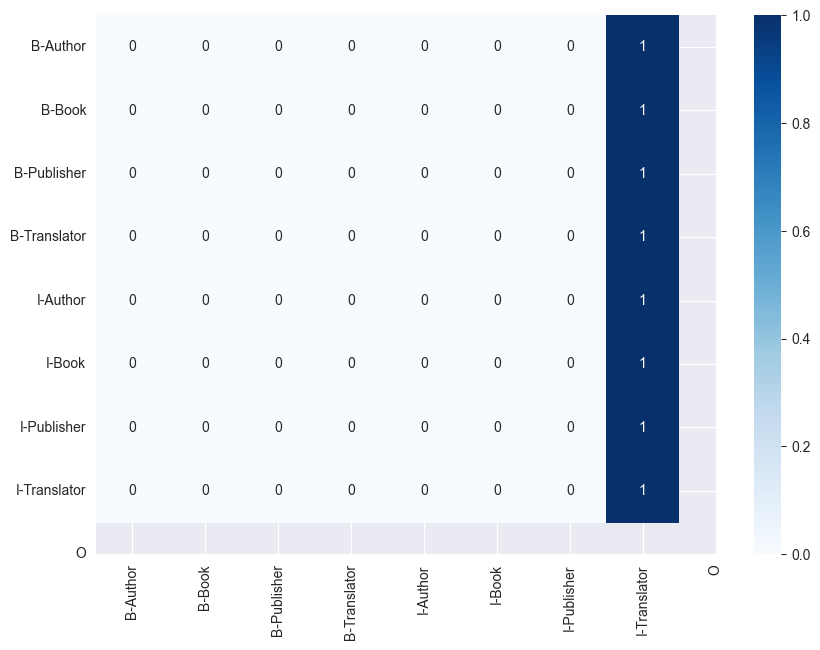

In [72]:
cm = confusion_matrix(y_true, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, xticklabels=tags, yticklabels=tags, cmap='Blues')
plt.show()

In [75]:
print('Accuracy:', accuracy_score(y_true, y_pred))
print()
print('Micro Precision:', precision_score(y_true, y_pred, average='micro'))
print('Macro Precision:', precision_score(y_true, y_pred, average='macro'))
print('Weighted Precision:', precision_score(y_true, y_pred, average='weighted'))
print()
print('Micro Recall:', recall_score(y_true, y_pred, average='micro'))
print('Macro Recall:', recall_score(y_true, y_pred, average='macro'))
print('Weighted Recall:', recall_score(y_true, y_pred, average='weighted'))
print()
print('Micro F1-score:', f1_score(y_true, y_pred, average='micro'))
print('Macro F1-score:', f1_score(y_true, y_pred, average='macro'))
print('Weighted F1-score:', f1_score(y_true, y_pred, average='weighted'))

Accuracy: 0.9951171875

Micro Precision: 0.9951171875
Macro Precision: 0.1243896484375
Weighted Precision: 0.9902582168579102

Micro Recall: 0.9951171875


/Users/AMF/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/AMF/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro Recall: 0.125
Weighted Recall: 0.9951171875

Micro F1-score: 0.9951171875
Macro F1-score: 0.12469407733724915
Weighted F1-score: 0.9926817563020068
